# ELMo for Aspect-Target Sentiment Classification (Russian language) - 2

В этом ноутбуке мы попробуем применить модель ELMoCNN к ATSC на русском языке. Будем использовать предобученную ELMo модель от RusVectores, построенную на токенах (есть еще модель, построенная на леммах).

In [0]:
# !pip install transformers
# !pip install allennlp

In [2]:
import time
import os
import gc
import zipfile
import random
from collections import defaultdict

import pandas as pd
import numpy as np
import torch
import gensim
import nltk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import bs4

from tqdm.notebook import tqdm

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
from torch.utils.data import Dataset as TorchDataset
from torch.utils.data import DataLoader

from allennlp.modules.elmo import Elmo, batch_to_ids
from transformers import AdamW

from IPython.display import clear_output

from google.colab import drive

USE_GOOGLE_DRIVE = True

sns.set(font_scale=1.2)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Примонтируем наш гугл-диск, если мы решили его использовать.

In [3]:
if USE_GOOGLE_DRIVE:
    drive.mount('/content/drive')
    PATH_PREFIX = 'drive/My Drive/NLP/dialog-sent'
else:
    PATH_PREFIX = '..'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
DATA_PREFIX = os.path.join(PATH_PREFIX, 'data')
MODEL_PREFIX = os.path.join(PATH_PREFIX, 'models')

Зададим девайс для обучения.

In [5]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


Проинициализируем везде генераторы случайных чисел.

In [0]:
random_seed = 42
random_state = random_seed

def set_seed_everywhere(seed, cuda):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    if cuda:
        torch.cuda.manual_seed_all(seed)

set_seed_everywhere(random_seed, USE_GPU)

### Данные для русскоязычного датасета

Теперь надо разобраться с данными. Мы используем отзывы о рестранах. В каждом отзыве есть т.н. аспектные термины, по которым мы должны указать тональность. В качестве примера можно привести отзыв из датасета:
```xml
	<review id="15655">
		<meta>
			<object>Roll &amp; Roll</object>
			<user>kazah</user>
			<date>29.05.2010 18:39</date>
			<useful>1</useful>
		</meta>
		<scores>
			<food>10</food>
			<interior>10</interior>
			<service>10</service>
		</scores>
		<text>Сегодня посетили этот ресторан с девушкой. Очень понравилось. Интерьер отличный, все из дерева и очень красиво! Официанты внимательны и ненавязчивы! Играет приятная музыка! 
        Что касается кухни: Остался в восторге от теплого салата с говядиной, и конечно стейк из говядины! Еще не могу не отметить крем-суп из лосося! 
        Ребята просто молодцы - очень очень вкусно! И порции &quot;достойные&quot;. В общем были приятно удивлены таким замечательным местом, обязательно придем еще, и не один раз!</text>
		<aspects>
			<aspect category="Whole" from="22" mark="Rel" sentiment="neutral" term="ресторан" to="30" type="explicit"/>
			<aspect category="Interior" from="62" mark="Rel" sentiment="positive" term="Интерьер" to="70" type="explicit"/>
			<aspect category="Interior" from="81" mark="Rel" sentiment="positive" term="все из дерева" to="94" type="fct"/>
			<aspect category="Service" from="112" mark="Rel" sentiment="positive" term="Официанты" to="121" type="explicit"/>
			<aspect category="Service" from="122" mark="Rel" sentiment="positive" term="внимательны" to="133" type="implicit"/>
			<aspect category="Interior" from="165" mark="Rel" sentiment="positive" term="музыка" to="171" type="explicit"/>
			<aspect category="Food" from="186" mark="Rel" sentiment="positive" term="кухни" to="191" type="explicit"/>
			<aspect category="Food" from="215" mark="Rel" sentiment="positive" term="теплого салата с говядиной" to="241" type="explicit"/>
			<aspect category="Food" from="253" mark="Rel" sentiment="positive" term="стейк из говядины" to="270" type="explicit"/>
			<aspect category="Food" from="296" mark="Rel" sentiment="positive" term="крем-суп из лосося" to="314" type="explicit"/>
			<aspect category="Food" from="352" mark="Rel" sentiment="positive" term="вкусно" to="358" type="implicit"/>
			<aspect category="Food" from="362" mark="Rel" sentiment="positive" term="порции" to="368" type="explicit"/>
			<aspect category="Whole" from="432" mark="Rel" sentiment="positive" term="местом" to="438" type="explicit"/>
		</aspects>
		<categories>
			<category name="Food" sentiment="positive"/>
			<category name="Interior" sentiment="positive"/>
			<category name="Price" sentiment="absence"/>
			<category name="Whole" sentiment="positive"/>
			<category name="Service" sentiment="positive"/>
		</categories>
	</review>
```
Как видим, здесь весьма много аспектных терминов в отличие от англоязычного датасета. Аттрибуты from, to указывают на позицию термина в предложении.



Данные предоставлены в формате xml. Для работы с ними будем использовать beautiful soup.

In [0]:
def xml2pandas(data_path):
    """Перевод исходного датасета в формате xml в pandas-датафрейм."""
    data_dict = {'sentence_id': [], 'text': [], 'term': [],
                 'from': [], 'to': [], 'sentiment': []}

    with open(data_path, 'r') as inf:
        contents = inf.read()
        soup = bs4.BeautifulSoup(contents, 'xml')
        for review in soup.find_all('review'):
            # Если нет аспектных терминов
            if review.find('aspects') is None:
                continue
            terms = review.find('aspects').find_all(
                'aspect'
            )
            for term in terms:
                data_dict['term'].append(term['term'])
                data_dict['from'].append(term['from'])
                data_dict['to'].append(term['to'])
                data_dict['sentiment'].append(term['sentiment'])

                data_dict['sentence_id'].append(review['id'])
                data_dict['text'].append(review.find('text').text)

    data = pd.DataFrame(data_dict)
    data['from'] = data['from'].astype(int)
    data['to'] = data['to'].astype(int)
    return data

In [0]:
data_train_raw_path = os.path.join(
    DATA_PREFIX, 'raw', 'SentiRuEval-2015', 'SentiRuEval_rest_markup_train.xml'
)

data_test_raw_path = os.path.join(
    DATA_PREFIX, 'raw', 'SentiRuEval-2015', 'SentiRuEval_rest_markup_test.xml'
)

data_train = xml2pandas(data_train_raw_path)
data_test = xml2pandas(data_test_raw_path)

In [9]:
data_train.head()

,sentence_id,text,term,from,to,sentiment
0,3976,"День 8-го марта прошёл, можно и итоги подвести...",ресторане,71,80,neutral
1,3976,"День 8-го марта прошёл, можно и итоги подвести...",ресторанах,198,208,neutral
2,3976,"День 8-го марта прошёл, можно и итоги подвести...",ресторане,256,265,neutral
3,3976,"День 8-го марта прошёл, можно и итоги подвести...",Столик бронировали,267,285,neutral
4,3976,"День 8-го марта прошёл, можно и итоги подвести...",сделали так как предложил администратор,296,335,positive


In [10]:
data_test.head()

,sentence_id,text,term,from,to,sentiment
0,37784,По совету друзей посетили данное заведение. Бы...,заведение,33,42,neutral
1,37784,По совету друзей посетили данное заведение. Бы...,Очень людно,68,79,negative
2,37784,По совету друзей посетили данное заведение. Бы...,пиво,93,97,positive
3,37784,По совету друзей посетили данное заведение. Бы...,большой выбор,104,117,positive
4,37784,По совету друзей посетили данное заведение. Бы...,кухни,122,127,neutral


Теперь, чтобы нормально это обучать надо как-то сохранить информацию о местопложении аспектных терминов (иначе токенизация порушит наши индексы, и они перестанут работать). В общем случае, нам надо хранить слайс индексов, которые будут отвечать за аспектный термин после токенизации.

Чтобы выполнить токенизацию и понять, где все еще находится аспектный термин, нам потребуется поставить какие-то маркеры. Попробуем проверить, что в наших текстах нет символов <, >, которыми мы обозначим границы аспектных терминов.

In [12]:
print(data_train['text'].apply(lambda x: '<' in x).sum())
print(data_test['text'].apply(lambda x: '>' in x).sum())
print(data_test['text'].apply(lambda x: '<' in x).sum())
print(data_test['text'].apply(lambda x: '>' in x).sum())

0
0
0
0


Обрамим аспектные термины символами <, >, чтобы потом после токенизации сразу понять, где они.

In [11]:
data_train.head()

,sentence_id,text,term,from,to,sentiment
0,3976,"День 8-го марта прошёл, можно и итоги подвести...",ресторане,71,80,neutral
1,3976,"День 8-го марта прошёл, можно и итоги подвести...",ресторанах,198,208,neutral
2,3976,"День 8-го марта прошёл, можно и итоги подвести...",ресторане,256,265,neutral
3,3976,"День 8-го марта прошёл, можно и итоги подвести...",Столик бронировали,267,285,neutral
4,3976,"День 8-го марта прошёл, можно и итоги подвести...",сделали так как предложил администратор,296,335,positive


In [13]:
!python -m spacy download xx_ent_wiki_sm
!python -m spacy validate

✔ Download and installation successful
You can now load the model via spacy.load('xx_ent_wiki_sm')
✔ Loaded compatibility table

====================== Installed models (spaCy v2.1.9) ======================
ℹ spaCy installation: /usr/local/lib/python3.6/dist-packages/spacy

TYPE      NAME             MODEL            VERSION                            
package   xx-ent-wiki-sm   xx_ent_wiki_sm   2.1.0   ✔
package   en-core-web-sm   en_core_web_sm   2.2.5   --> 2.1.0     


============================== Install updates ==============================
Use the following commands to update the model packages:
python -m spacy download en_core_web_sm



In [0]:
nlp = spacy.load('xx_ent_wiki_sm')

In [0]:
def tokenize(df_orig, nlp):
    df = df_orig.copy()
    from_tokens = []
    to_tokens = []
    tokenized_texts = []
    for i, row in df.iterrows():
        raw_text = row['text']
        from_index = row['from']
        to_index = row['to']
        text = (raw_text[:from_index] + '< ' + raw_text[from_index:to_index] 
                + ' >' + raw_text[to_index:])
        doc = nlp(text)
        tokens = [x.text for x in doc]
        tokenized_texts.append([x for x in tokens if x not in ['<', '>']])
        try:
            from_tokens.append(tokens.index('<') + 1)
            to_tokens.append(tokens.index('>'))
        except ValueError as e:
            print(raw_text)
            print(tokens)
    df['from'] = from_tokens
    df['to'] = to_tokens
    df['text'] = tokenized_texts
    return df

In [16]:
data_train = tokenize(data_train, nlp)
data_test = tokenize(data_test, nlp)
data_train.head()

,sentence_id,text,term,from,to,sentiment
0,3976,"[День, 8-го, марта, прошёл, ,, можно, и, итоги...",ресторане,15,16,neutral
1,3976,"[День, 8-го, марта, прошёл, ,, можно, и, итоги...",ресторанах,34,35,neutral
2,3976,"[День, 8-го, марта, прошёл, ,, можно, и, итоги...",ресторане,47,48,neutral
3,3976,"[День, 8-го, марта, прошёл, ,, можно, и, итоги...",Столик бронировали,49,51,neutral
4,3976,"[День, 8-го, марта, прошёл, ,, можно, и, итоги...",сделали так как предложил администратор,53,58,positive


Проверим, что ничего не сломалось.

In [17]:
print(data_train['text'].apply(lambda x: '<' in ''.join(x)).sum())
print(data_train['text'].apply(lambda x: '>' in ''.join(x)).sum())
print(data_test['text'].apply(lambda x: '<' in ''.join(x)).sum())
print(data_test['text'].apply(lambda x: '>' in ''.join(x)).sum())

0
0
0
0


Теперь можем разделить данные на валидацию и трейн.

In [18]:
data_train, data_valid = train_test_split(
    data_train, test_size=0.2, random_state=random_state
)

print(f'TRAIN SIZE: {data_train.shape[0]}')
print(f'VALIDATE SIZE: {data_valid.shape[0]}')
print(f'TEST SIZE: {data_test.shape[0]}')

TRAIN SIZE: 3488
VALIDATE SIZE: 873
TEST SIZE: 5117


Посмотрим на сбалансированность классов.

In [19]:
np.unique(data_train.sentiment)

array(['both', 'negative', 'neutral', 'positive'], dtype=object)

In [20]:
np.unique(data_train.sentiment, return_counts=True)[1] / data_train.shape[0]

array([0.01290138, 0.17230505, 0.19466743, 0.62012615])

In [21]:
np.unique(data_valid.sentiment, return_counts=True)[1] / data_valid.shape[0]

array([0.01145475, 0.16609393, 0.18556701, 0.63688431])

In [22]:
np.unique(data_test.sentiment, return_counts=True)[1] / data_test.shape[0]

array([0.01700215, 0.18350596, 0.09595466, 0.70353723])

Классы, конечно, не сбалансированны, но доли классов на трейне и валидации очень близки. Смущает то, что доля нейтральных на тесте чуть ли не в два раза ниже, чем на трейне. Видим два пути для борьбы с дизбалансом классов:
1. Использование весов в лоссе.
2. Использование Random Oversampling для редких классов на этапе формирования батча.

#### Создание датасета и даталоадера для обучения

In [0]:
data_train, data_valid = train_test_split(
    data_train, test_size=0.2, random_state=random_state
)

In [0]:
sentiment_vocab = {'negative': 0, 'positive': 1, 'both': 2, 'neutral': 3}

In [0]:
class Dataset(TorchDataset):
    
    """Custom data.Dataset compatible with data.DataLoader."""
    def __init__(self, data, sentiment_vocab):
        self.data = data
        self.sentiment_vocab = sentiment_vocab

    def __getitem__(self, index):
        """
        Returns one tensor pair (source and target). The source tensor corresponds to the input word,
        with "BEGIN" and "END" symbols attached. The target tensor should contain the answers
        for the language model that obtain these word as input.        
        """
        text = self.data['text'].iloc[index]
        from_index = torch.tensor([self.data['from'].iloc[index]], 
                                  dtype=torch.long)
        to_index = torch.tensor([self.data['to'].iloc[index]], dtype=torch.long)
        sentiment = torch.tensor(
            [self.sentiment_vocab[self.data['sentiment'].iloc[index]]], 
            dtype=torch.long
        )
        return (text, from_index, to_index, sentiment)

    def __len__(self):
        return len(self.data)

In [0]:
def collate_fn(batch):
    """Специальная функция для обработки паддингов."""
    # распакуем батч
    text, from_index, to_index, sentiment = zip(*batch)
    # состакаем все кроме текстов (с ними потом разберется сам ELMo)
    from_index = torch.stack(from_index)
    to_index = torch.stack(to_index)
    sentiment = torch.stack(sentiment)
    return text, from_index, to_index, sentiment

Проверим, что батчи работают правильно.

In [27]:
train_dataset = Dataset(data_train, sentiment_vocab)
dataloader_train = DataLoader(train_dataset, batch_size=5, 
                              shuffle=True, num_workers=4, 
                              collate_fn=collate_fn)

for i_batch, (text_batched, from_batched, to_batched, 
              sentiment_batched) in enumerate(dataloader_train):
    if i_batch == 1:
        break
    print(from_batched)
    print(from_batched.size())

tensor([[168],
        [ 37],
        [ 34],
        [ 60],
        [ 21]])
torch.Size([5, 1])


### ELMoCNN

Возьмем лучшую модель из 5-db-elmo.ipynb.

In [0]:
class ELMOCNN(nn.Module):

    def __init__(self, num_sentiments, elmo, embeddings_dim, 
                 hidden_dim, kernel_sizes,
                 device):
        super(ELMOCNN, self).__init__()

        self.device = device

        self.elmo = elmo
        self.elmo_layer_coef_1 = nn.Parameter(torch.ones(1))
        self.elmo_layer_coef_2 = nn.Parameter(torch.ones(1))

        self.convs1 = nn.ModuleList(
            [nn.Conv1d(embeddings_dim, hidden_dim, kernel_size) 
            for kernel_size in kernel_sizes]
        )
        self.convs1_nonlin = nn.ReLU()
        self.convs1_dropout = nn.Dropout()

        self.to_sentiments = nn.Linear(2*len(kernel_sizes)*hidden_dim, 
                                       num_sentiments)

        # weights initializatioin
        torch.nn.init.xavier_uniform_(self.to_sentiments.weight)
        
    def forward(self, texts, from_indices, to_indices, hidden=None):
        # get elmo embeddings
        character_ids = batch_to_ids(texts).to(device=self.device)
        embeddings_raw = self.elmo(character_ids)['elmo_representations']
        embeddings = (
            embeddings_raw[0] * self.elmo_layer_coef_1 
            + embeddings_raw[1] * self.elmo_layer_coef_2
        )

        # get bit matrix
        batch_size, seq_len, _ = embeddings.size()
        index_matrix = torch.repeat_interleave(
            torch.arange(seq_len).view(1, -1), batch_size, dim=0
        ).to(device=self.device)
        bit_matrix = ((index_matrix >= from_indices) 
                      & (index_matrix < to_indices))
        # inverse bit matrix to work with context
        bit_matrix = ~bit_matrix
        # get average of embedings according to bit_matrix
        embeddings = embeddings*torch.unsqueeze(bit_matrix, -1)
        embeddings = torch.transpose(embeddings, 1, 2)
        x = [self.convs1_nonlin(conv(embeddings)) for conv in self.convs1]

        list_to_cat = [torch.max(y, 2)[0] for y in x]
        list_to_cat += [torch.mean(y, 2) for y in x]
        x = torch.cat(list_to_cat, 1)
        x = self.convs1_dropout(x)
        sentiments = self.to_sentiments(x)
        return sentiments

Инициализируем сеть и генератор эмбеддингов.

In [0]:
set_seed_everywhere(random_seed, USE_GPU)

num_sentiments = len(sentiment_vocab) - 1 # выкидываем neutral

options_file = os.path.join(
    DATA_PREFIX, 'raw', 'ELMo', 
    'ruwikiruscorpora_tokens_elmo_1024_2019', 'options.json'
)
weight_file = os.path.join(
    DATA_PREFIX, 'raw', 'ELMo', 
    'ruwikiruscorpora_tokens_elmo_1024_2019', 'model.hdf5'
)

elmo = Elmo(options_file, weight_file, 2, dropout=0)

hidden_dim = 32

model = ELMOCNN(
    num_sentiments, elmo, 1024, hidden_dim, [3, 5, 7], device
)


#### Цикл обучения

In [0]:
def plot_learning_curves(history):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param history: (dict)
        accuracy и loss на обучении и валидации
    '''
    sns.set_style(style='whitegrid')
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Macro F1 score', fontsize=15)
    plt.plot(history['f1']['train'], label='train')
    plt.plot(history['f1']['val'], label='val')
    plt.ylabel('f1 score', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [0]:
def train_loop(train_iter, val_iter, model, optimizer, scheduler, criterion, epochs, 
               early_stopping, path_save, path_best_save, save_every_epoch=5, history=None):

    if history is None:
        history = defaultdict(lambda: defaultdict(list))

    best_val_loss = 100
    best_val_score = 0
    not_improves = 0
    for epoch in range(1, epochs + 1):

        start_time = time.time()
        train_loss = 0.0
        train_score = 0.0
        val_loss = 0.0
        val_acc = 0.0

        train_preds = []
        train_answers = []
        model.train() 
        for batch in tqdm(train_iter, leave=False): 

            texts, from_indices, to_indices, sentiments = batch
            from_indices = from_indices.to(device=device)
            to_indices = to_indices.to(device=device)
            sentiments = sentiments.to(device=device).squeeze(1)

            optimizer.zero_grad()
            preds = model(texts, from_indices, to_indices)

            loss = criterion(preds, sentiments)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), grad_clipping_value)
            optimizer.step()
            train_loss += loss.item()

            pred_sentiments = torch.max(preds, dim=-1)[1]
            train_preds += pred_sentiments.tolist()
            train_answers += sentiments.tolist()

        train_loss /= len(train_iter.dataset)
        train_preds = np.array(train_preds)
        train_answers = np.array(train_answers)
        train_score = f1_score(train_answers, train_preds, average='macro')
        history['loss']['train'].append(train_loss)
        history['f1']['train'].append(train_score)

        val_preds = []
        val_answers = []
        model.eval()
        with torch.no_grad():
            for batch in val_iter:

                texts, from_indices, to_indices, sentiments = batch
                from_indices = from_indices.to(device=device)
                to_indices = to_indices.to(device=device)
                sentiments = sentiments.to(device=device).squeeze(1)

                preds = model(texts, from_indices, to_indices)

                preds = model(texts, from_indices, to_indices)  
                loss = criterion(preds, sentiments)
                val_loss += loss.item()
                
                pred_sentiments = torch.max(preds, dim=-1)[1]
                val_preds += pred_sentiments.tolist()
                val_answers += sentiments.tolist()

        val_loss /= len(valid_iter.dataset)
        val_preds = np.array(val_preds)
        val_answers = np.array(val_answers)
        val_score = f1_score(val_answers, val_preds, average='macro')
        history['loss']['val'].append(val_loss)
        history['f1']['val'].append(val_score)

        if val_score > best_val_score:
            not_improves = 0
            best_val_score = val_score
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'sheduler_state_dict': scheduler.state_dict(),
                'history': dict(history)
                }, path_best_save)
            print('------SAVED BEST------')
        else:
            not_improves += 1
            if not_improves == early_stopping:
                break

        if (epoch-1) % save_every_epoch == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'sheduler_state_dict': scheduler.state_dict(),
                'history': dict(history)
                }, path_save)
            print('------SAVED------')
        
        scheduler.step()

        clear_output()

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch, epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training f1: \t\t\t{:.2f} %".format(train_score * 100))
        print("  validation f1: \t\t\t{:.2f} %".format(val_score * 100))
        
        plot_learning_curves(history)

    return model, history

Для того, чтобы получать сравнимые с соревнованием результаты, будем брать те же самые сентименты (там при расчете результатов не учитывался neutral).

In [0]:
remain_sentiments = ['positive', 'negative', 'both']
train_dataset = Dataset(
    data_train[data_train.sentiment.isin(remain_sentiments)], 
    sentiment_vocab
)
valid_dataset = Dataset(
    data_valid[data_valid.sentiment.isin(remain_sentiments)], 
    sentiment_vocab
)

In [0]:
labels = [x[-1].item() for x in train_dataset]
weights_classes = 1/np.unique(labels, return_counts=True)[1]
weights_samples = [weights_classes[x] for x in labels]

In [0]:
train_sampler = torch.utils.data.WeightedRandomSampler(
    weights_samples, num_samples=len(train_dataset)
)

In [0]:
batch_size = 64

train_iter = DataLoader(train_dataset, batch_size=batch_size, 
                        shuffle=False, num_workers=4, collate_fn=collate_fn, 
                        sampler=train_sampler)

valid_iter = DataLoader(valid_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=4, collate_fn=collate_fn)

In [0]:
path_save = os.path.join(MODEL_PREFIX, 'elmo', 'elmo_cnn_russian_3.pt')
path_best_save = os.path.join(MODEL_PREFIX, 'elmo', 'elmo_cnn_russian_3_best.pt')

In [0]:
checkpoint = torch.load(path_best_save)
model.load_state_dict(checkpoint['model_state_dict'])
history = checkpoint['history']

In [0]:
model = model.to(device=device)
learning_rate = 1e-4
early_stopping = 100
grad_clipping_value = 1
epochs = 5

optimizer = AdamW(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=1)
criterion = nn.CrossEntropyLoss(reduction='sum')

Epoch 5 of 5 took 141.659s
  training loss (in-iteration): 	0.146595
  validation loss (in-iteration): 	0.486384
  training f1: 			94.74 %
  validation f1: 			54.72 %


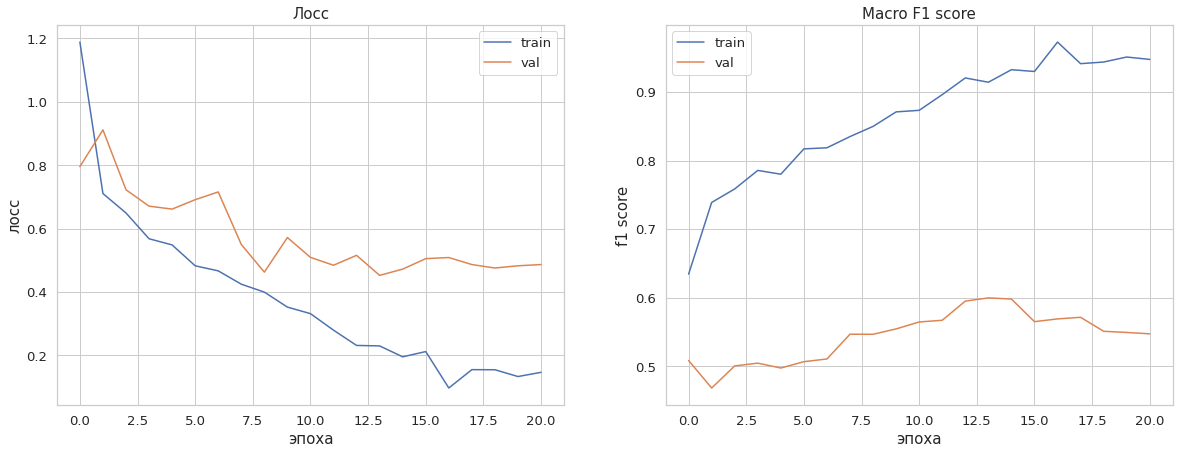

In [0]:
set_seed_everywhere(random_seed, USE_GPU)
model, history = train_loop(
    train_iter, valid_iter, model, optimizer, scheduler, criterion, 
    epochs, early_stopping, path_save, path_best_save, history=history
)

### Тестирование

In [0]:
path_best_load = os.path.join(MODEL_PREFIX, 'elmo', 'elmo_cnn_russian_3_best.pt')

In [0]:
checkpoint = torch.load(path_best_load)
model.load_state_dict(checkpoint['model_state_dict'])
history = checkpoint['history']

In [0]:
remain_sentiments = ['both', 'positive', 'negative']
test_dataset = Dataset(
    data_test[data_test.sentiment.isin(remain_sentiments)], 
    sentiment_vocab
)

test_iter = DataLoader(test_dataset, batch_size=64, shuffle=False, 
                       num_workers=4, collate_fn=collate_fn)

In [39]:
model.eval().to(device=device)

all_preds = []
all_answers = []
with torch.no_grad():
    for batch in tqdm(test_iter):

        texts, from_indices, to_indices, sentiments = batch
        from_indices = from_indices.to(device=device)
        to_indices = to_indices.to(device=device)
        sentiments = sentiments.to(device=device).squeeze(1)

        preds_scores = model(texts, from_indices, to_indices)
        preds = torch.max(preds_scores, dim=-1)[1]
        all_preds += preds.tolist()
        all_answers += sentiments.tolist()

all_preds = np.array(all_preds)
all_answers = np.array(all_answers)

In [40]:
np.unique(all_preds, return_counts=True)

(array([0, 1]), array([ 851, 3775]))

In [41]:
np.unique(all_answers, return_counts=True)

(array([0, 1, 2]), array([ 939, 3600,   87]))

In [42]:
accuracy = accuracy_score(all_answers, all_preds)
f_score_macro = f1_score(all_answers, all_preds, average='macro')
f_score_micro = f1_score(all_answers, all_preds, average='micro')

print(f'Accuracy: {accuracy:.3f}')
print(f'F1 Macro: {f_score_macro:.3f}')
print(f'F1 Micro: {f_score_micro:.3f}')

Accuracy: 0.851
F1 Macro: 0.521
F1 Micro: 0.851


In [43]:
sentiment_vocab

{'both': 2, 'negative': 0, 'neutral': 3, 'positive': 1}

In [44]:
confusion_matrix(all_answers, all_preds)

array([[ 585,  354,    0],
       [ 249, 3351,    0],
       [  17,   70,    0]])

Измерим качество лучшей полученной модели. Она была обучена Adam: сначала lr=1e-3 первые 20 эпох, а потом lr=1e-4 оставшиеся 5 эпох.

Сравним результаты различных наших моделей с тем, что дает лучшее решение SentiRuEval:

* F1-Micro: $0.825$
* F1-Macro: $0.555$.

1) ElmoCNN-Russian-2
Для борьбы с дибалансом классов модель использовала веса для лосса: `[3, 1, 10]`, что в итоге не сильно помогло ситуации. Модель совсем неправильно предсказывает both и часто путает positive и negative.

Результат:
* F1-Micro: $0.855$
* F1-Macro: $0.520$.

2) ElmoCNN-Russian-3
Для борьбы с дибалансом классов использовался второй метод с batch random oversampling, что в итоге не помогло ситуации. Модель совсем неправильно предсказывает both и часто путает positive и negative.

Результат:
* F1-Micro: $0.851$
* F1-Macro: $0.521$.

### Выводы

К сожалению, модель пока не удалось перенести с хорошим качеством. Возможные причины:
* Плохо обрабатывается дизбаланс классов (об этом говорят результаты тестирования, где модель не угадала вообще класс both) даже когда пытались это исправить.